# Integrating Python, SQL, and Tableau
Data scientists and analysts have many tools at their disposal. Though there is often overlap between the capabilities of various tools, each one has its own set of strenghts and weaknesses. Rather than having to choose one, it's best to integrate them all together so that we can get the best of both worlds. 

- **Python** is a powerful scripting language with libraries that make it ideal for performing sophisticated machine learning analyses. It also has libraries that allow for keeping limited amounts of information in memory for those analyses, as well as for providing basic visualizations of the data.
- **SQL** is a database tool that is manages vast quantities of data, as well as their relationships. Though not an analytical nor visualization tool, it provides the means to quickly and easily get to the relevant subsets of data required.
- **Tableau** is a visualization tool which are much more suitable for presentation purposes. Though it is possible to construct data from scratch and compute values across rows and columns, it normally just reads data from csv or SQL. 

Through integration, we can get the analytical prowess of Python, the data management sophistication of SQL, and the beatification of Tableau to present the findings of data. We will show how this is accomplished through a simple analysis: predicting absenteeism.

## Project Overview: Predicting Absenteeism
There are many reasons a person might be unable to work. Some are within a company's control, and some aren't. For example, a company might have a high-stress culture that causes people to get sick more often. On the other hand, a person who is pregnant is going to miss work for an extended period irregardless of company behavior. A firm is going to need to respond to these situations in different ways. If we can predict when a person is likely to miss time from work and understand why, it will allow the company to be more proactive in dealing with it. 

We start by using OSEMN framework to complete the analysis, build our machine learning model, and prepare it for deployment.

## Obtaining the Data
We start by loading the data in the file **absenteeism_data.csv**, along with relevant libraries. We use the *pandas_profiling* module to provide a complete overview of our data. It will provide necessary insights to identify null values, duplicate rows, correlation coefficients & heat maps, etc. 

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt

raw_data = pd.read_csv('absenteeism_data.csv')

data = raw_data.copy()
data.profile_report()

### Initial Observations
Target variable will be **Absenteeism_Time_in_Hours** for a given day. 

The **Reason_for_Absence** is actually a categorical column, but it is difficult to say whether or not this will be an effective predictor. We do not generally know the reason until after a person has already called out. We will treat it as a predictor for the time being, but depending on the strength of the relationship, it is likely we will need to develop a new model to predict if a given reason is likely to be exhibited by a person. For example, if a reason is sickness, we would want to know if there is a way to predict that someone might get sick. Though it may make the model stronger, there are practical implications to consider. 

## Scrubbing the Data
### Warnings
By looking at the *Warnings* section, we can get a sense of what will need to be cleaned up.

- Remove duplicate rows
- Rows with zeros in **Absenteeism_Time_in_Hours** column will be dropped
- Get dummies for **Reason_for_Absence** column and group in the following manner

 - **Reasons 1-14**: Sickness
 - **Reasons 15-17**: Pregnancy
 - **Reasons 18-21**: Injury
 - **Reasons 22-28**: Doctor Appointment

In addition, the **ID** column is not necessary for the analysis, so this column will be dropped.

In [17]:
# Drop duplicate rows
data.drop_duplicates(inplace=True)

# Drop rows with 0 hours absent
df = data[data['Absenteeism_Time_in_Hours'] != 0]

# Reset index
df = df.reset_index(drop=True)

# Create reason groups
reasons = {'Sickness': list(range(1, 15)), 
           'Pregnancy': list(range(15, 18)), 
           'Injury': list(range(18, 22)), 
           'Doctors_Appt': list(range(22, 29))}

# Get dummies
for reason in reasons.keys():
    df[reason] = [1 if num in reasons[reason] else 0 for num in df['Reason_for_Absence']]
    
# Drop Reason & ID columns
df.drop(['Reason_for_Absence', 'ID'], axis=1, inplace=True)
df.head()

Date  Transportation_Expense  Distance_to_Work  Age  \
0  07/07/2015                     289                36   33   
1  15/07/2015                     179                51   38   
2  16/07/2015                     279                 5   39   
3  23/07/2015                     289                36   33   
4  10/07/2015                     179                51   38   

   Daily_Work_Load_Average  Body_Mass_Index  Education  Children  Pets  \
0                  239.554               30          1         2     1   
1                  239.554               31          1         0     0   
2                  239.554               24          1         2     0   
3                  239.554               30          1         2     1   
4                  239.554               31          1         0     0   

   Absenteeism_Time_in_Hours  Sickness  Pregnancy  Injury  Doctors_Appt  
0                          4         0          0       0             1  
1                          2         0          0       0             1  
2                          4         1          0       0             0  
3                          2         0          0       0             1  
4                          2         0          0       0             1

### Time of Week / Year
Does day of the week matter? Are individuals more likely to call out on Monday or Friday? What about time of year? We will extract the day of the week and month name from the date column to see if that makes a difference.

In [20]:
# Convert date column to datetime format
df.Date = pd.to_datetime(df.Date)

# Get day name dummies
df['Weekday'] = [date.weekday() for date in df.Date]
df['Month'] = [month.month for month in df['Date']]

df.drop('Date', axis=1, inplace=True)
df.head()

Transportation_Expense  Distance_to_Work  Age  Daily_Work_Load_Average  \
0                     289                36   33                  239.554   
1                     179                51   38                  239.554   
2                     279                 5   39                  239.554   
3                     289                36   33                  239.554   
4                     179                51   38                  239.554   

   Body_Mass_Index  Education  Children  Pets  Absenteeism_Time_in_Hours  \
0               30          1         2     1                          4   
1               31          1         0     0                          2   
2               24          1         2     0                          4   
3               30          1         2     1                          2   
4               31          1         0     0                          2   

   Sickness  Pregnancy  Injury  Doctors_Appt  Weekday  Month  
0         0          0       0             1        1      7  
1         0          0       0             1        2      7  
2         1          0       0             0        3      7  
3         0          0       0             1        3      7  
4         0          0       0             1        2     10

### Education
This variable is categorical, representing various levels of education. One (1) indicates high school has been completed, while the remaining indicate that a higher level of education has been completed. The data is highly skewed with a vast majority of employees only finishing high school. It would make sense to make this column binary, with one (1) indicating that the person has education beyond high school, and 0 representing high school education only.

In [21]:
df.Education = [1 if lvl > 1 else 0 for lvl in df.Education]
df.Education.value_counts()

0    539
1    114
Name: Education, dtype: int64

### Write Preprocessed File to CSV

In [22]:
df.to_csv('df_preprocessed.csv')

## Data Exploration & Feature Engineering
Read preprocessed data and generate new profile report.

In [23]:
clean_df = pd.read_csv('df_preprocessed.csv', index_col=0)
clean_df.profile_report()

### Observations
With the data cleaned, we can examine the correlations among variables. Not surprisingly, injury and sickness have the greatest positive correlation with hours missed in a given day. However, when someone leaves work for a doctor’s appointment, the time lost is very little. 

In addition, the number of children a person has a slightly positive correlation with hours missed.

We also see a strong, positive correlation between Age and BMI, as does the relationship between number of children and pets with transportation expense. The strength of correlation does not seem significant enough to require dropping any variables, but if it does prove necessary, it will be best to drop BMI since age seems to have a stronger correlation with the target variable. In addition, transportation expenses would be dropped since we can get greater insights by considering the number of children and pets. 

Finally, we do see strong, negative correlation between doctor's appointments and sickness/injury. This is likely due to the simple fact that employees are likely to list one or the other as a reason for absence as opposed to both.

### Feature Engineering
Perform min-max scaling and log transformation on continuous/semi-continuous numerical variables:
- Absensteeism Time
- Daily Work Load
- BMI 
- Age
- Distance to Work
- Transportation Expenses

In [24]:
from sklearn.preprocessing import MinMaxScaler

transformed_df = clean_df.copy()

# Identify columns to transform
columns = ['Absenteeism_Time_in_Hours', 
           'Daily_Work_Load_Average', 
           'Body_Mass_Index', 
           'Age', 
           'Distance_to_Work', 
           'Transportation_Expense']

# Log transformation & MinMax Scaling
for col in columns:
    transformed_df[col] = np.log(transformed_df[col])

scaler = MinMaxScaler()
transformed_df[columns] = scaler.fit_transform(transformed_df[columns])

# Generate profile report for transformed columns
transformed_df[columns + ['Pets', 'Children']].profile_report()

## Modeling
We will attempt multiple model types in an effort to predict number of absentee hours in a given day. We will perform an 80/20 train/test split, and use k-fold cross-validation with 5 folds of training data before attempting to predict test results.

### Train / Test Split

In [25]:
from sklearn.model_selection import train_test_split

X = transformed_df.drop('Absenteeism_Time_in_Hours', axis=1)
y = transformed_df['Absenteeism_Time_in_Hours']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, 
                                                    random_state=123)

### Linear Regression Model

In [26]:
def plot_predictions(y_test, y_hat_test, k, Target):
    plt.figure(figsize=(20, 5))
    plt.plot(y_hat_test, y_hat_test, label='Predicted')
    plt.scatter(y_hat_test, y_test, color='r', marker='.', label='Actual')
    plt.title(f'{k}\nPredicted {Target} vs Actual {Target}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.show()

Explained Variance Score: 6.78%


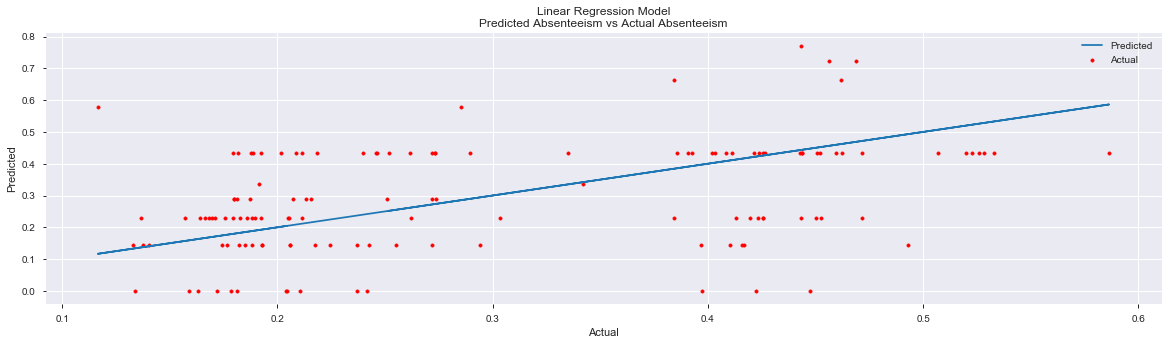

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_test = linreg.predict(X_test)
score = explained_variance_score(y_test, y_hat_test)

print(f'Explained Variance Score: {100*score:.2f}%')
plot_predictions(y_test, y_hat_test, 'Linear Regression Model', 'Absenteeism')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 135 out of 135 | elapsed:    4.6s finished




Best XGBoost Pipeline Training Score:	 29.04%
Best XGBoost Pipeline Test Score:	-34.18%

Best Parameters:
  colsample_bytree: 0.75
  gamma: 0.0005
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 100
  subsample: 0.75

Potential Decrease in Absenteeism Time In Hours: 43.72%


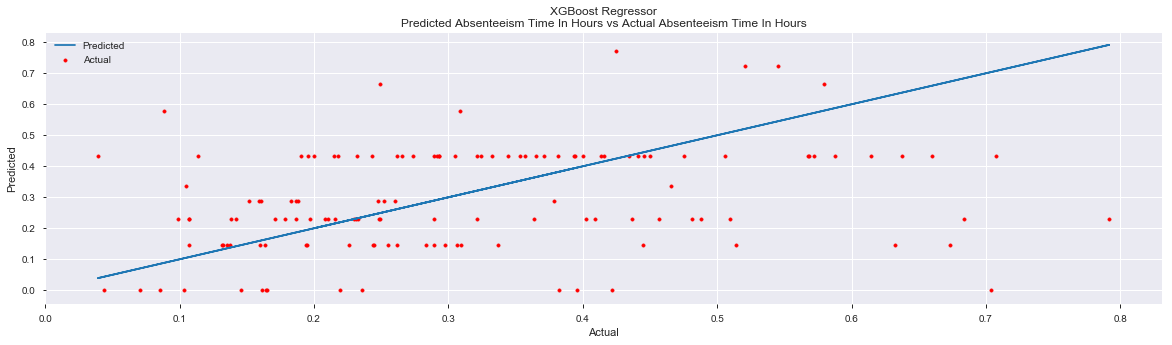

In [28]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

target = 'Absenteeism_Time_in_Hours'
Target = target.replace('_', ' ').title()
    
# Set accuracy measure
acc_meas = 'explained_variance'

# Create pipeline (PCA found to hinder results too much)
xgb_pipe = Pipeline([#('pca', PCA(n_components=n_feat, random_state=123)), 
                     ('xgbreg', xgb.XGBRegressor(random_state=123))])

# Create search grid
xgb_grid = {'xgbreg__learning_rate': [.1],
            'xgbreg__max_depth': [5, 7, 9],
            'xgbreg__gamma': [.0005],
            'xgbreg__subsample': [.25, .5, .75], 
            'xgbreg__colsample_bytree': [.5, .75, 1],
            'xgbreg__n_estimators': [100]}

# Use gridsearch across 5 crossfolds of data for each test set
xgb_gridsearch = GridSearchCV(estimator = xgb_pipe, 
                              param_grid = xgb_grid, 
                              scoring = acc_meas, 
                              cv = 5, verbose = 1,
                              n_jobs=8,
                              return_train_score = True)

# Fit model to data
xgb_gridsearch.fit(X_train, y_train)

# Make predictions for test set
y_hat_test = xgb_gridsearch.predict(X_test)

# Measure difference between all "no" and all "yes" responses
min_max_df = pd.DataFrame([[0 for i in range(len(X_test.columns))], 
                           [1 for i in range(len(X_test.columns))]], columns=X_test.columns)
min_max_preds = xgb_gridsearch.predict(min_max_df)
min_max_pct_diff = (min_max_preds[0] - min_max_preds[1]) / min_max_preds[0]

# Display results
print(f'\n\nBest XGBoost Pipeline Training Score:\t{100 * xgb_gridsearch.best_score_: .2f}%')
print(f'Best XGBoost Pipeline Test Score:\t{100 * explained_variance_score(y_test, y_hat_test): .2f}%\n\nBest Parameters:')
for param in xgb_gridsearch.best_params_.keys():
    print(f'  {param.split("__")[1]}: {xgb_gridsearch.best_params_[param]}')

print(f'\nPotential Decrease in {Target}: {min_max_pct_diff*100:.2f}%')

# Plot predicted values against actual values
plot_predictions(y_test, y_hat_test, 'XGBoost Regressor', Target)